# 事例2: obspyを使って地震解析

## 2-1 地震波解析

- ### 必要なライブラリの読み込み．

In [3]:
import obspy
from obspy.core import read
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

- ### 東北地方太平洋沖地震のデータをFSDNにリクエスト． https://www.fdsn.org/webservices/
- ### ファイルフォーマットは国際標準の.seed形式のバイナリデータとなる
- ### ちなみに日本の地震学業界は.win形式という独自のバイナリデータで運用しているので，日本の観測データはFSDNから取ることができない…．

- ### obspyには"obspy.clients.fdsn.mass_downloader"という一括ダウンローダがある．便利．
- ### 東北地方太平洋沖地震の震源付近の観測データを指定して.seed形式の地震波形ファイルを手に入れる．

In [ ]:
"""
origin_time = obspy.UTCDateTime(2011, 3, 11, 5, 47, 32)

domain = CircularDomain(latitude=37.52, longitude=143.04,
                        minradius=70.0, maxradius=90.0)

restrictions = Restrictions(
    starttime=origin_time - 5 * 60,
    endtime=origin_time + 3600,
    reject_channels_with_gaps=True,
    minimum_length=0.95,
    minimum_interstation_distance_in_m=10E3,
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
    location_priorities=["", "00", "10"])

mdl = MassDownloader()
mdl.download(domain, restrictions, mseed_storage="waveforms",
             stationxml_storage="stations")
"""

[2016-09-20 21:08:10,363] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for BGR, EMSC, ETH, GEONET, GFZ, INGV, IPGP, ISC, KOERI, LMU, NCEDC, NIEP, NOA, RESIF, SCEDC, USGS, USP, ORFEUS, IRIS.
[2016-09-20 21:08:10,955] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'ISC' as it does not have 'dataselect' and/or 'station' services.
[2016-09-20 21:08:11,063] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'USGS' as it does not have 'dataselect' and/or 'station' services.
[2016-09-20 21:08:11,347] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'EMSC' as it does not have 'dataselect' and/or 'station' services.
[2016-09-20 21:08:11,510] - obspy.clients.fdsn.mass_downloader - INFO: Cannot use client 'ORFEUS' as it does not have 'dataselect' and/or 'station' services.
[2016-09-20 21:08:12,354] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 15 client(s): BGR, ETH, GEONET, GFZ, INGV, IPGP, KOERI, LMU, 

- ### 仕方ないので，ドイツのニーダーザクセンにある観測所を適当に選ぶ
- ### 観測所はここ．http://geofon.gfz-potsdam.de/waveform/status/station.php?network=GR&station=NRDL

In [4]:
st = read('waveforms/GR.NRDL..HHZ__20110311T054232Z__20110311T064732Z.mseed')
print(st)

1 Trace(s) in Stream:
GR.NRDL..HHZ | 2011-03-11T05:42:31.448411Z - 2011-03-11T06:47:33.498411Z | 100.0 Hz, 390206 samples


- ### ファイルの情報を見る

In [5]:
st[0].stats

         network: GR
         station: NRDL
        location: 
         channel: HHZ
       starttime: 2011-03-11T05:42:31.448411Z
         endtime: 2011-03-11T06:47:33.498411Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 390206
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'record_length': 512, 'encoding': u'STEIM2', 'filesize': 752128, u'dataquality': u'D', 'number_of_records': 1469, 'byteorder': u'>'})

- ### 時系列の地震波形をみる
- ### ドイツの観測ステーションなのに明らかに東北地方太平洋沖地震の地震波が到達している

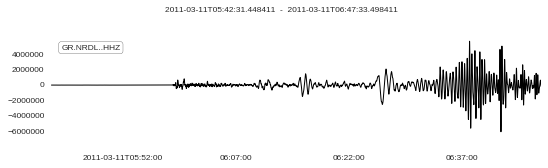

In [6]:
st.plot()

- ### 適切に15分ごとに折り返して見ることもできる．

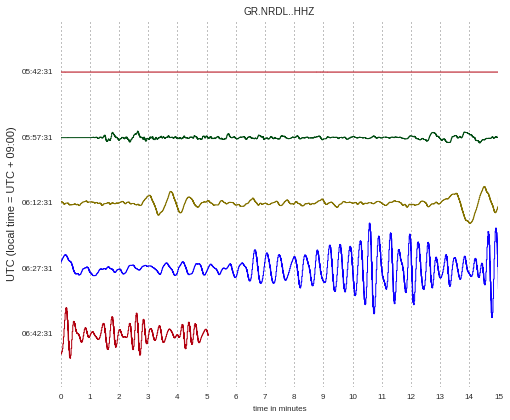

In [7]:
st.plot(type='dayplot')

- ### 地震波は波形なので当然スペクトラムを書いて，波形解析ができる．

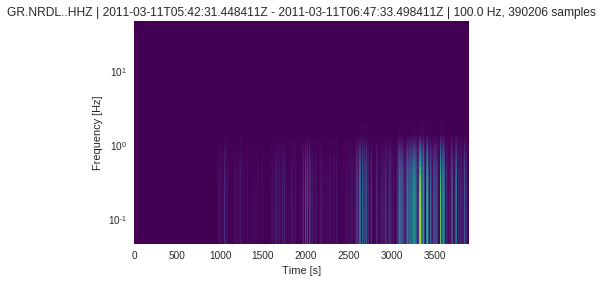

[None]

In [8]:
st.spectrogram(log=True)

- ### 信号処理の基本で周波数フィルタをかける．
- ### ハイパスフィルタの例

In [9]:
st.filter("highpass", freq=1, corners=2)

1 Trace(s) in Stream:
GR.NRDL..HHZ | 2011-03-11T05:42:31.448411Z - 2011-03-11T06:47:33.498411Z | 100.0 Hz, 390206 samples

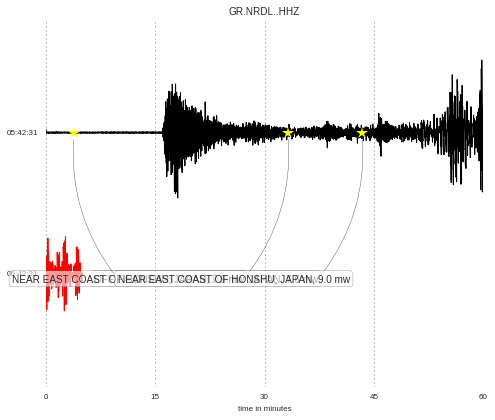

In [10]:
st.plot(type="dayplot", interval=60, right_vertical_labels=False,
        vertical_scaling_range=5e4, one_tick_per_line=True,
        color=['k', 'r', 'b', 'g'], show_y_UTC_label=False,
        events={'min_magnitude': 6.5})

## 2-2 地震イベント探索

- ### FSDNで地震イベントを検索
- ### まずはRESTクライアントをたてる

In [11]:
from obspy.clients.fdsn import Client
client = Client("IRIS")

- ### FSDNが提供している地震イベントの提供先カタログ一覧
- ### もちろんガラパゴス・ジャパンは存在しない…

In [12]:
from obspy.clients.fdsn.header import URL_MAPPINGS
for key in sorted(URL_MAPPINGS.keys()):
    print("{0:<7} {1}".format(key,  URL_MAPPINGS[key]))

BGR     http://eida.bgr.de
EMSC    http://www.seismicportal.eu
ETH     http://eida.ethz.ch
GEONET  http://service.geonet.org.nz
GFZ     http://geofon.gfz-potsdam.de
INGV    http://webservices.rm.ingv.it
IPGP    http://eida.ipgp.fr
IRIS    http://service.iris.edu
ISC     http://isc-mirror.iris.washington.edu
KOERI   http://eida.koeri.boun.edu.tr
LMU     http://erde.geophysik.uni-muenchen.de
NCEDC   http://service.ncedc.org
NIEP    http://eida-sc3.infp.ro
NOA     http://eida.gein.noa.gr
ODC     http://www.orfeus-eu.org
ORFEUS  http://www.orfeus-eu.org
RESIF   http://ws.resif.fr
SCEDC   http://service.scedc.caltech.edu
USGS    http://earthquake.usgs.gov
USP     http://sismo.iag.usp.br


- ### 気を取り直して，IRISカタログに2011-03-10から2011-03-12までのマグニチュード6以上の地震イベントを検索

In [13]:
starttime = obspy.UTCDateTime("2011-03-10")
endtime = obspy.UTCDateTime("2011-03-12")
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=6, catalog="ISC")
print(cat)

46 Event(s) in Catalog:
2011-03-11T20:11:23.520000Z | +39.011, +142.777 | 6.1 MW
2011-03-11T19:46:50.050000Z | +40.404, +139.154 | 6.2 MW
...
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
2011-03-10T17:08:37.320000Z |  -6.857, +116.730 | 6.6 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


- ### 検索したカタログをプロットする

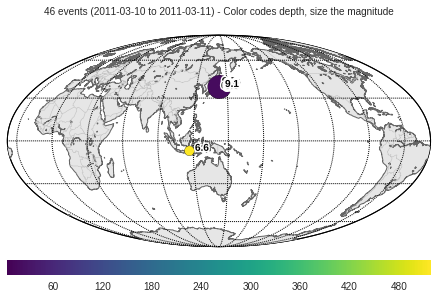

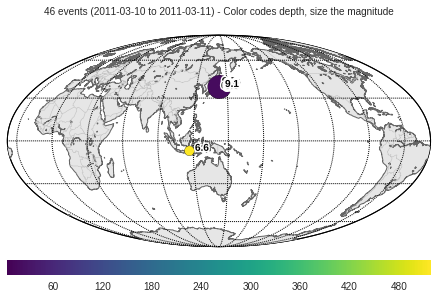

In [14]:
cat.plot()

- ### 同じ時期にインドネシアでもマグニチュード6.6の地震があったことがわかる